### Preprocessing and Modeling: Sentiment Analysis For Customer Interactions In X (Formerly Twitter)

This notebook is structured to guide through the preprocessing and modeling stages of a sentiment analysis project. The primary objective is to categorize X (formerly Twitter) customer support interactions into distinct sentiment classes. This involves transforming cleaned tweet data for machine learning applications and performing sentiment analysis to extract meaningful business insights.

#### Preprocessing
- **Objective**: Ready the cleaned dataset for detailed sentiment analysis and feature extraction.
- **Key Steps**:
  - Application of advanced NLP techniques like lemmatization and removal of stopwords to refine the text data.
  - Execution of feature engineering to extract significant attributes from the data, including text length, frequency of product mentions, and sentiment scores.
  - Development of additional derived features such as part-of-speech tags and named entity recognition to enhance the dataset's richness.

#### Feature Extraction and Selection
- **Objective**: Extract and identify key features for the sentiment analysis model.
- **Methodology**:
  - Employment of TF-IDF vectorization to numerically represent text data, highlighting word significance within the dataset.
  - Incorporation of count-based features like noun and adjective counts, adding depth to the model's understanding.
  - Selection of a diversified set of text-based and derived features to form a comprehensive input for the model.

#### Model Building and Evaluation
- **Objective**: Develop and evaluate models for classifying tweets into sentiment categories.
- **Approach**:
  - Exploration of various machine learning models including Logistic Regression, Support Vector Machine, Random Forest, and Gradient Boosting Machines.
  - Assessment of model performance using metrics such as accuracy, precision, recall, and F1-score to gauge effectiveness.
  - Optimization of model parameters and feature selection to enhance accuracy and performance.

#### Sentiment Classification
- **Objective**: Precise classification of customer interactions into positive, negative, or neutral sentiments.
- **Details**:
  - Integration of trained models for predicting sentiment labels on new data.
  - Analysis of model predictions to gain insights into customer sentiment trends and brand performance.

#### Final Model Selection and Deployment Considerations
- **Objective**: Identify the most effective model and plan its deployment.
- **Strategy**:
  - Comparison of different models to select the most suitable one for sentiment classification.
  - Discussion of potential deployment methodologies, including options for real-time analysis and integration within customer support frameworks.

This notebook underscores the significance of meticulous data preparation, strategic feature engineering, and judicious model selection in sentiment analysis, aiming to showcase advanced data science proficiency and a pragmatic approach to addressing real-world problems.

In [8]:
import sys
sys.path.append('../scripts/')

In [9]:
# imports for processing
import logging
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [10]:
# imports for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from joblib import load, dump
import pickle
from sklearn.preprocessing import LabelEncoder
import logging
import warnings
from utils import *
from sklearn.model_selection import train_test_split

In [11]:
# setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# set up spacy 
nlp = spacy.load('en_core_web_sm')

#### Loading Cleaned Data:

In [4]:
try: 
    file_path = '../data/interim/cleaned_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-11 17:02:00,621 - INFO - Starting execution of load_data
2023-12-11 17:02:01,211 - INFO - Data loading completed successfully
2023-12-11 17:02:01,214 - INFO - Data loaded successfully


In [5]:
df.head()

,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,sentiment,message_length
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,33
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,i have sent several private messages and no on...,-0.2960,70
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,i did,0.0000,5
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service,-0.6249,29
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0,you gonna magically change your connectivity f...,0.0000,71


In [6]:
df['cleaned_text'] = df['cleaned_text'].astype(str)

In [7]:
df['cleaned_text'].apply(type).value_counts()

cleaned_text
<class 'str'>    100000
Name: count, dtype: int64

#### Preprocessing:

We will perform a series of steps to transform the data for modeling by doing this, we ensure the consistency on responses. We will also add some engineered features that will enhance the model for the response generation.

In [8]:
df['processed'] = df['cleaned_text'].apply(preprocess_text)
df['processed_text'] = df['processed'].apply(lambda x: x['processed_text'])
df['pos_tags'] = df['processed'].apply(lambda x: x['pos_tags'])
df['noun_count'] = df['pos_tags'].apply(lambda tags: tags.count('NOUN'))
df['adj_count'] = df['pos_tags'].apply(lambda tags: tags.count('ADJ'))
# text complexity
df['text_complexity'] = df['processed_text'].apply(lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0)

In [9]:
# saving preprocessed data to csv
folder_path2 = '../data/'  # Adjust the path as needed
file_name2 = 'processed/processed_data.csv'
full_path2 = save_data(df, folder_path2, file_name2)

if full_path2:
    print(f"DataFrame saved at: {full_path2}")
else:
    print("Failed to save the DataFrame.")

2023-12-11 18:15:18,644 - INFO - DataFrame saved successfully to ../data/processed/processed_data.csv


DataFrame saved at: ../data/processed/processed_data.csv


In [10]:
# Apply NER
df['entities'] = df['text'].apply(extract_entities)
# count product mention
df['product_mentions'] = df['entities'].apply(lambda ents: sum('PRODUCT' in ent for ent in ents))
# text length in processed-lemmatized text
df['text_length'] = df['processed_text'].apply(len)
# brands count
df['brand_mentions'] = df['entities'].apply(lambda ents: sum('ORG' in ent for ent in ents))

In [11]:
# saving preprocessed data to csv
folder_path2 = '../data/'  # Adjust the path as needed
file_name2 = 'processed/processed_data.csv'
full_path2 = save_data(df, folder_path2, file_name2)

if full_path2:
    print(f"DataFrame saved at: {full_path2}")
else:
    print("Failed to save the DataFrame.")

2023-12-11 18:28:47,857 - INFO - DataFrame saved successfully to ../data/processed/processed_data.csv


DataFrame saved at: ../data/processed/processed_data.csv


In [4]:
try: 
    file_path = '../data/processed/processed_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-12 10:25:52,083 - INFO - Starting execution of load_data
2023-12-12 10:25:53,212 - INFO - Data loading completed successfully
2023-12-12 10:25:53,217 - INFO - Data loaded successfully


In [6]:
# creating dependent variable
def categorize_sentiment(score, pos_threshold=0.1, neg_threshold=-0.1):
    """
    Categorize sentiment score into classes with error handling and logging.
    Args:
    score (float): Sentiment score.
    pos_threshold (float): Threshold for positive sentiment.
    neg_threshold (float): Threshold for negative sentiment.
    Returns:
    str: Sentiment category ('Positive', 'Negative', 'Neutral').
    """
    try:
        if score > pos_threshold:
            sentiment = 'Positive'
        elif score < neg_threshold:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        return sentiment
    except Exception as e:
        logging.error(f"Error in categorizing sentiment: {e}")
        return 'Neutral'


df['derived_sentiment'] = df['sentiment'].apply(categorize_sentiment)

In [7]:
df.head()

,tweet_id,author_id,created_at,text,response_tweet_id,in_response_to_tweet_id,cleaned_text,sentiment,message_length,processed,processed_text,pos_tags,noun_count,adj_count,text_complexity,entities,product_mentions,text_length,brand_mentions,derived_sentiment
0,2,115712,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0,and how do you propose we do that,0.0000,33,"{'processed_text': 'propose', 'pos_tags': ['CC...",propose,"['CCONJ', 'SCONJ', 'AUX', 'PRON', 'VERB', 'PRO...",0,0,1.0,[],0,7,0,Neutral
1,3,115712,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0,i have sent several private messages and no on...,-0.2960,70,{'processed_text': 'send private message respo...,send private message respond usual,"['PRON', 'AUX', 'VERB', 'ADJ', 'ADJ', 'NOUN', ...",2,3,1.0,[],0,34,0,Negative
2,5,115712,2017-10-31 21:49:35,@sprintcare I did.,4,6.0,i did,0.0000,5,"{'processed_text': '', 'pos_tags': ['PRON', 'V...",NaN,"['PRON', 'VERB']",0,0,0.0,[],0,0,0,Neutral
3,8,115712,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service,-0.6249,29,"{'processed_text': 'bad customer service', 'po...",bad customer service,"['AUX', 'DET', 'ADJ', 'NOUN', 'NOUN']",2,1,1.0,[],0,20,0,Negative
4,12,115713,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0,you gonna magically change your connectivity f...,0.0000,71,{'processed_text': 'gon na magically change co...,gon na magically change connectivity family,"['PRON', 'VERB', 'PART', 'ADV', 'VERB', 'PRON'...",2,1,1.0,[],0,43,0,Neutral


#### Feature Engineering:


In [10]:
df['processed_text'] = df['processed_text'].fillna('')

# TF-IDF Vectorization
try:
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
# Combine TF-IDF with other features
    additional_features = df[['noun_count', 'product_mentions', 'text_length', 'brand_mentions', 'adj_count', 'text_complexity']].values
    X_combined = hstack([X_tfidf, additional_features])
except Exception as e: 
    logging.error(f"Error while performing TfidfVectorizer and/or combining features: {e}")
    raise

In [13]:
try: 
    y = df['derived_sentiment']
    
    X_train, X_test, y_train, y_test = split_data(X_combined, y, test_size=0.3)
    logging.info("Split data function applied successfully")
except Exception as e:
    logging.error(f"Error while splitting data: {e}")
    raise

2023-12-12 11:04:59,434 - INFO - Data successfully split into train and test sets.
2023-12-12 11:04:59,435 - INFO - Split data function applied successfully


#### Scaling features: 

Scaling is a crucial step before training a ML model to ensure the features are within the same mean and std. Below, we will extract the count-based features (features extracted previously and stacked horizontally with main feature: TF-IDF). Then, we will use MinMaxScaler to standardize them and finally stack them back with the main and already normalized TF-IDF features. 

In [16]:
from sklearn.preprocessing import MaxAbsScaler

# number of count-based features
num_count_features = 6

try: # Extract count-based features from the end of each row in X_train and X_test
    X_train_counts = X_train[:, -num_count_features:]
    X_test_counts = X_test[:, -num_count_features:]

    # Normalize these features
    scaler = MaxAbsScaler()
    X_train_counts_scaled = scaler.fit_transform(X_train_counts)
    X_test_counts_scaled = scaler.transform(X_test_counts)

    # Recombine with the TF-IDF features
    X_train_scaled = hstack([X_train[:, :-num_count_features], X_train_counts_scaled])
    X_test_scaled = hstack([X_test[:, :-num_count_features], X_test_counts_scaled])
    logging.info("Count-based features scaled successfully")
except Exception as e: 
    logging.error(f"Error while scaling count-based features: {e}")
    raise

2023-12-12 11:15:25,850 - INFO - Count-based features scaled successfully


In [ ]:
# encoding y_train and y_test for XGBoost Modeling
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Paths for saving the datasets
X_train_path = '../data/processed/X_train_scaled.joblib'
X_test_path = '../data/processed/X_test_scaled.joblib'
y_train_path = '../data/processed/y_train.joblib'
y_test_path = '../data/processed/y_test.joblib'
y_train_encoded_path = '../data/processed/y_train_encoded.joblib'
y_test_encoded_path = '../data/processed/y_test_encoded.joblib'

# Saving the datasets
try:
    dump(X_train_scaled, X_train_path)
    logging.info(f"X_train_scaled saved successfully at {X_train_path}")

    dump(X_test_scaled, X_test_path)
    logging.info(f"X_test_scaled saved successfully at {X_test_path}")

    dump(y_train, y_train_path)
    logging.info(f"y_train saved successfully at {y_train_path}")

    dump(y_test, y_test_path)
    logging.info(f"y_test saved successfully at {y_test_path}")

    dump(y_train_encoded, y_train_encoded_path)
    logging.info(f"y_train_encoded saved successfully at {y_train_encoded_path}")

    dump(y_test_encoded, y_test_encoded_path)
    logging.info(f"y_test_encoded saved successfully at {y_test_encoded_path}")
except Exception as e:
    logging.error(f"Error while saving datasets: {e}")

### Model Building, Training, and Testing: Sentiment Analysis Project

This section of the notebook is dedicated to building, training, and testing various machine learning models for sentiment analysis. Our goal is to classify Twitter customer support interactions into sentiment categories: positive, negative, or neutral. We have chosen four models for this task, each with distinct characteristics and strengths:

#### 1. Logistic Regression
- **Approach**: We will tune hyperparameters like regularization strength (C) and iteration count, striving for a balance between model simplicity and predictive performance.

#### 2. Support Vector Machine (SVM)
- **Approach**: We'll explore both linear and non-linear kernels, aiming to capture complex patterns in the data while maintaining model efficiency.

#### 3. Random Forest Classifier
- **Approach**: We will focus on tuning tree-specific parameters like the number of trees and tree depth to optimize performance and prevent overfitting.

#### 4. Gradient Boosting Machines (XGBoost)
- **Approach**: We'll implement careful tuning of learning rate, number of estimators, and tree complexity, aiming to enhance the model's ability to sequentially learn from misclassified data points.


### Testing and Evaluation:
For each model, we'll perform the following:
- **Cross-Validation**: To ensure robustness and generalizability, we'll use cross-validation techniques during hyperparameter tuning.
- **Model Evaluation**: Post-training, we'll assess each model on the test dataset using metrics such as accuracy, precision, recall, and F1-score, providing a holistic view of each model's performance.

The selection of these models demonstrates a strategic approach to tackling a real-world sentiment analysis task, showcasing a solid grasp of data science principles and the ability to apply different machine learning techniques effectively.

In [27]:
# Initializing an empty DataFrame to store all model scores
all_model_scores = pd.DataFrame(columns=['Model', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])

##### Logistic Regression:

In [32]:
logreg_model = LogisticRegression(max_iter=1000)

# Evaluate the model
logreg_scores = evaluate_model(logreg_model, "Logistic Regression", X_train_scaled, y_train)

# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, logreg_scores], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-12 17:20:15,937 - INFO - Logistic Regression evaluation completed successfully.
2023-12-12 17:20:15,938 - INFO - Model scores appended successfully.


##### Support Vector Classifier (SVM)

In [34]:
svc_model = SVC(kernel='linear', cache_size=1000, tol=0.01)

# Evaluate the model
svc_scores = evaluate_model(svc_model, "Support Vector Classifier(SVM)", X_train_scaled, y_train)

# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, svc_scores], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-12 18:54:39,855 - INFO - Support Vector Classifier(SVM) evaluation completed successfully.
2023-12-12 18:54:39,856 - INFO - Model scores appended successfully.


#### Random Forest Classifier

In [36]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Evaluate the model
rf_scores = evaluate_model(rf_model, "Random Forest Classifier", X_train_scaled, y_train)

# Append to the master DataFrame
try:
    all_model_scores = pd.concat([all_model_scores, rf_scores], ignore_index=True)
    logging.info("Model scores appended successfully.")
except Exception as e:
    logging.error(f"Error appending model scores: {e}")

2023-12-12 19:22:28,734 - INFO - Random Forest Classifier evaluation completed successfully.
2023-12-12 19:22:28,736 - INFO - Model scores appended successfully.


#### XGBoost Classifier

In [39]:
# Train the XGBoost model with encoded labels
xgb_model = XGBClassifier(eval_metric='mlogloss')

# Evaluate the model
try:
    xgb_scores = evaluate_model(xgb_model, "XGBoost Classifier", X_train_scaled, y_train_encoded)
    all_model_scores = pd.concat([all_model_scores, xgb_scores], ignore_index=True)
    logging.info("XGBoost Classifier scores appended successfully.")
except Exception as e:
    logging.error(f"Error evaluating XGBoost Classifier: {e}")

2023-12-12 20:06:16,574 - INFO - XGBoost Classifier evaluation completed successfully.
2023-12-12 20:06:16,575 - INFO - XGBoost Classifier scores appended successfully.


#### Hyperparameter Tunning:

In [12]:
# loading the data
# Paths where the datasets were saved
X_train_path = '../data/processed/X_train_scaled.joblib'
X_test_path = '../data/processed/X_test_scaled.joblib'
y_train_path = '../data/processed/y_train.joblib'
y_test_path = '../data/processed/y_test.joblib'
y_train_encoded_path = '../data/processed/y_train_encoded.joblib'
y_test_encoded_path = '../data/processed/y_test_encoded.joblib'

# Loading the datasets
try:
    X_train_scaled = load(X_train_path)
    logging.info("X_train_scaled loaded successfully.")

    X_test_scaled = load(X_test_path)
    logging.info("X_test_scaled loaded successfully.")

    y_train = load(y_train_path)
    logging.info("y_train loaded successfully.")

    y_test = load(y_test_path)
    logging.info("y_test loaded successfully.")

    y_train_encoded = load(y_train_encoded_path)
    logging.info("y_train_encoded loaded successfully.")

    y_test_encoded = load(y_test_encoded_path)
    logging.info("y_test_encoded loaded successfully.")
except Exception as e:
    logging.error(f"Error while loading datasets: {e}")

2023-12-13 19:28:34,707 - INFO - X_train_scaled loaded successfully.
2023-12-13 19:28:34,712 - INFO - X_test_scaled loaded successfully.
2023-12-13 19:28:34,720 - INFO - y_train loaded successfully.
2023-12-13 19:28:34,725 - INFO - y_test loaded successfully.
2023-12-13 19:28:34,728 - INFO - y_train_encoded loaded successfully.
2023-12-13 19:28:34,729 - INFO - y_test_encoded loaded successfully.


In [15]:
# Initializing an empty DataFrame to store all tunned model scores 
all_model_scores2 = pd.DataFrame(columns=['Model', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])

In [16]:
# function to get model scores and store them in a df
def get_best_model_scores(random_search_cv, model_name):
    """
    Extracts the best scores from a RandomizedSearchCV object.
    Args:
    random_search_cv: The RandomizedSearchCV object.
    model_name (str): Name of the model.
    Returns:
    pd.DataFrame: A DataFrame with performance metrics for the best model.
    """
    try:
        # Extracting the best scores
        best_score = random_search_cv.best_score_
        best_params = random_search_cv.best_params_
        best_index = random_search_cv.best_index_

        # Retrieving the scores
        best_accuracy = random_search_cv.cv_results_['mean_test_accuracy'][best_index]
        best_precision = random_search_cv.cv_results_['mean_test_precision_macro'][best_index]
        best_recall = random_search_cv.cv_results_['mean_test_recall_macro'][best_index]
        best_f1 = random_search_cv.cv_results_['mean_test_f1_macro'][best_index]

        # Creating a DataFrame row
        df_row = pd.DataFrame({
            'Model': [f"{model_name} (Tuned)"],
            'Accuracy': [best_accuracy],
            'Precision': [best_precision],
            'Recall': [best_recall],
            'F1 Score': [best_f1]
        })

        logging.info(f"Best scores for {model_name} extracted successfully.")
        return df_row
    except Exception as e:
        logging.error(f"Error in extracting best scores for {model_name}: {e}")
        return pd.DataFrame({
            'Model': [f"{model_name} (Tuned)"],
            'Accuracy': [None],
            'Precision': [None],
            'Recall': [None],
            'F1 Score': [None]
        })

#### Tunning Logistic Regression Model

In [21]:
# import stats
from scipy.stats import loguniform

# warnings ignore
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Hyperparameter distributions
param_dist_logreg = {
    'C': loguniform(1e-2, 1e2),  # Log-uniform distribution
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none']
}

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# RandomizedSearchCV setup
random_search_logreg = RandomizedSearchCV(
    logreg, 
    param_distributions=param_dist_logreg, 
    n_iter=100,
    cv=5, 
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], 
    refit='f1_macro', 
    n_jobs=-1, 
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
try:
    random_search_logreg.fit(X_train_scaled, y_train)
    best_logreg = random_search_logreg.best_estimator_
    logging.info("Hyperparameter tuning for Logistic Regression completed successfully.")
except Exception as e:
    logging.error(f"Error during hyperparameter tuning for Logistic Regression: {e}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/nlp-c/lib/python3.9/site-packag

##### Serializing Tuned LogReg 

In [22]:
# Assuming random_search_logreg is your RandomizedSearchCV object for Logistic Regression
random_search_logreg_path = '../models/random_search_logreg.joblib'

try:
    dump(random_search_logreg, random_search_logreg_path)
    logging.info(f"RandomizedSearchCV object for Logistic Regression saved successfully at {random_search_logreg_path}")
except Exception as e:
    logging.error(f"Error saving the RandomizedSearchCV object for Logistic Regression: {e}")

2023-12-13 20:21:56,096 - INFO - RandomizedSearchCV object for Logistic Regression saved successfully at ../models/random_search_logreg.joblib


#### Metrics for LogReg to DataFrame

In [43]:
# getting best scores to a df
best_logreg_scores = get_best_model_scores(random_search_logreg, "Logistic Regression")
# Adding logreg scores to a df
all_model_scores2 = pd.concat([all_model_scores2, best_logreg_scores], ignore_index=True)

2023-12-13 22:26:29,764 - INFO - Best scores for Logistic Regression extracted successfully.


#### Tunning Random Forest Classifier Model

In [24]:
from scipy.stats import randint

# Hyperparameter distributions
param_dist_rf = {
    'n_estimators': randint(50, 200), 
    'max_depth': randint(3, 20),      
    'min_samples_split': randint(2, 10) 
}

# Random Forest model
rf = RandomForestClassifier()

# RandomizedSearchCV setup
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=100,  
    cv=5,       
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro'
    },
    refit='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
try:
    random_search_rf.fit(X_train_scaled, y_train)
    best_rf = random_search_rf.best_estimator_
    logging.info("Hyperparameter tuning for Random Forest completed successfully.")
except Exception as e:
    logging.error(f"Error during hyperparameter tuning for Random Forest: {e}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


2023-12-13 20:36:37,077 - INFO - Hyperparameter tuning for Random Forest completed successfully.
2023-12-13 20:37:12,149 - INFO - Random Forest (Tuned) evaluation completed successfully.


##### Serializing Tuned Random Forest

In [25]:
# path to model
random_search_rf_path = '../models/random_search_rf.joblib'

try:
    dump(random_search_rf, random_search_rf_path)
    logging.info(f"RandomizedSearchCV object for Random Forest Model saved successfully at {random_search_rf_path}")
except Exception as e:
    logging.error(f"Error saving the RandomizedSearchCV object for Random Forest Model: {e}")

2023-12-13 20:43:46,027 - INFO - RandomizedSearchCV object for Random Forest Model saved successfully at ../models/random_search_rf.joblib


In [44]:
# getting best scores to a dataframe
best_rf_scores = get_best_model_scores(random_search_rf, "Random Forest Classifier")
# Adding rf scores to a df
all_model_scores2 = pd.concat([all_model_scores2, best_rf_scores], ignore_index=True)

2023-12-13 22:26:34,207 - INFO - Best scores for Random Forest Classifier extracted successfully.


#### Tunning XGBoost Classifier Model

In [28]:
from scipy.stats import uniform

# Hyperparameter distributions
param_dist_xgb = {
    'n_estimators': randint(50, 200),   # Number of gradient boosted trees
    'learning_rate': uniform(0.01, 0.2), # Boosting learning rate
    'max_depth': randint(3, 10)          # Maximum depth of a tree
}

# XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss')

# RandomizedSearchCV setup
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Reduced iterations
    cv=5,       # Reduced cross-validation folds
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro'
    },
    refit='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Perform hyperparameter tuning
try:
    random_search_xgb.fit(X_train_scaled, y_train_encoded)  # Note: use y_train_encoded for XGBoost
    best_xgb = random_search_xgb.best_estimator_
    logging.info("Hyperparameter tuning for XGBoost completed successfully.")
except Exception as e:
    logging.error(f"Error during hyperparameter tuning for XGBoost: {e}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


2023-12-13 21:30:01,484 - INFO - Hyperparameter tuning for XGBoost completed successfully.
2023-12-13 21:31:20,292 - INFO - XGBoost (Tuned) evaluation completed successfully.


##### Serializing Tuned XGBoost Model 

In [29]:
# path to model
random_search_xgb_path = '../models/random_search_xgb.joblib'

try:
    dump(random_search_xgb, random_search_xgb_path)
    logging.info(f"RandomizedSearchCV object for XGBoost Model saved successfully at {random_search_xgb_path}")
except Exception as e:
    logging.error(f"Error saving the RandomizedSearchCV object for XGBoost Model: {e}")

2023-12-13 21:34:47,994 - INFO - RandomizedSearchCV object for XGBoost Model saved successfully at ../models/random_search_xgb.joblib


In [45]:
# getting best scores to a dataframe
best_xgb_scores = get_best_model_scores(random_search_xgb, "XGBoost Classifier")
# Adding rf scores to a df
all_model_scores2 = pd.concat([all_model_scores2, best_xgb_scores], ignore_index=True)

2023-12-13 22:26:40,905 - INFO - Best scores for XGBoost Classifier extracted successfully.


In [47]:
try:
    all_model_scores2 = all_model_scores2.drop([0, 1, 2, 3, 4, 5])
    logging.info("First three rows dropped successfully")
except Exception as e:
    logging.error(f"Error while dropping rows: {e}")
    raise

# displaying dataframe
all_model_scores2

2023-12-13 22:27:28,436 - INFO - First three rows dropped successfully


,Model,F1 Score,Accuracy,Recall,Precision
6,Logistic Regression (Tuned),0.764294,0.768771,0.764212,0.771032
7,Random Forest Classifier (Tuned),0.676217,0.680571,0.676561,0.680433
8,XGBoost Classifier (Tuned),0.749329,0.754357,0.749883,0.758123


#### Model Selection: Logistic Regression Tuned Model

In [48]:
# Logistic Regression (Tuned) has the highest scores
best_model = best_logreg  

##### Serializing Best Model

In [50]:
# best Logistic Regression model
best_model_path = '../models/best_logreg_model.joblib'  

# Save the model
try:
    dump(best_logreg, best_model_path)
    logging.info(f"Best Logistic Regression model saved successfully at {best_model_path}")
except Exception as e: 
    logging.erro(f"Error while saving the model: {e}")
    raise

2023-12-13 22:33:03,412 - INFO - Best Logistic Regression model saved successfully at ../models/best_logreg_model.joblib


##### Saving Metrics of Models

In [58]:
try:
    all_models_scores2.to_csv('../models/model_performance_metrics.csv', index=False)
    logging.info("Model performance metrics saved to '../models/model_performance_metrics.csv'")
except Exception as e: 
    logging.error(f"Error while saving metrics: {e}")
    raise

2023-12-13 23:42:08,976 - INFO - Model performance metrics saved to '../models/model_performance_metrics.csv'


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

#### Creating Feature Importance Plot

In [53]:
try: 
    file_path = '../data/processed/processed_data.csv'
    df = load_data(file_path=file_path)
    logging.info("Data loaded successfully")
except Exception as e:
    logging.error(f"Error while loading the dataset: {e}")

2023-12-13 23:33:03,660 - INFO - Starting execution of load_data
2023-12-13 23:33:04,765 - INFO - Data loading completed successfully
2023-12-13 23:33:04,769 - INFO - Data loaded successfully


In [55]:
df['processed_text'] = df['processed_text'].fillna('')
# Initialize TfidfVectorizer and fit it on the full dataset
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(df['processed_text'])

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Additional feature names used during model training
additional_features_names = ['noun_count', 'product_mentions', 'text_length', 'brand_mentions', 'adj_count', 'text_complexity']

# Combine all feature names
all_feature_names = np.concatenate((feature_names, additional_features_names))

# Extract the coefficients from the Logistic Regression model
feature_importances = best_logreg.coef_[0]

# Map feature names to their coefficients
feature_importance_dict = dict(zip(all_feature_names, feature_importances))

# Convert to a DataFrame for visualization
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Coefficient'])

# Sort the DataFrame by the absolute value of coefficients
feature_importance_df = feature_importance_df.reindex(feature_importance_df.Coefficient.abs().sort_values(ascending=False).index)

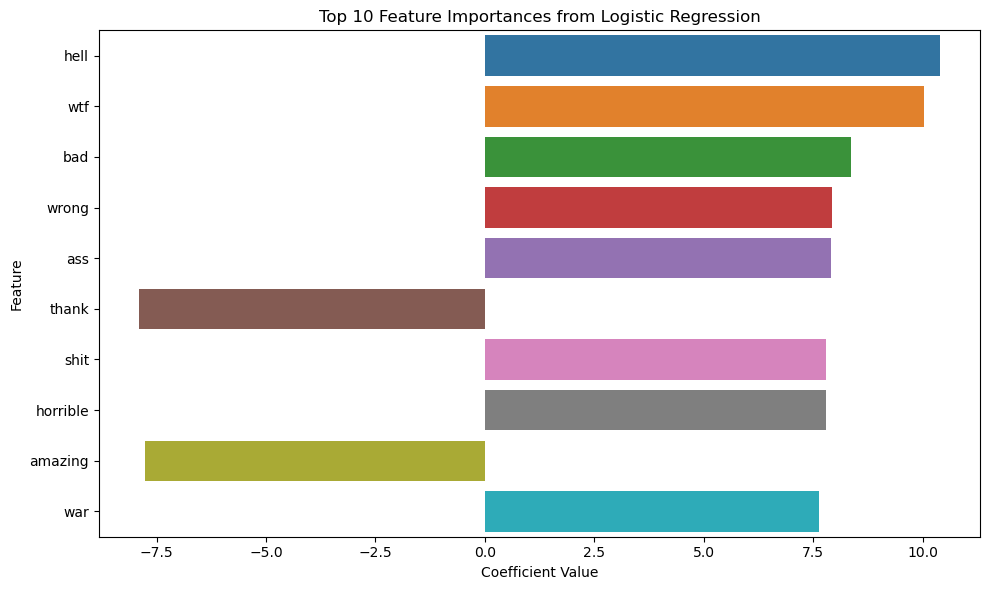

In [56]:
# Plot the top 10 feature importances
top_n = 10
top_features_df = feature_importance_df.head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features_df['Coefficient'], y=top_features_df['Feature'])
plt.title(f'Top {top_n} Feature Importances from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()